$$
\newcommand{\R}{\mathbb{R}}
\renewcommand{\b}{\mathbf}
\newcommand{\u}{\mathbf{u}}
\newcommand{\v}{\mathbf{v}}
$$


# Movie Recommendations

*Credits: this assignment adapted with permission from Dan Sheldon.*


| user  | Moonlight | The Shape of Water   | Frozen | Moana     |
|-------|-----------|----------------------|--------|-----------| 
|Alice  |   5       |          4           |    1   |           |
|Bob    |           |          5           |        |    2      |
|Carol  |           |                      |        |    5      |
|David  |           |                      |    5   |    5      |
|Eve    |   5       |          4           |        |           |


What movie should I recommend to Bob?
Will Carol like Frozen?

**Goal**: Fill in entries of the "rating matrix"

# Problem Setup

Let's formalize this as a machine learning problem. To make it concrete, let's load some data and see what it looks like.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import scipy.io

# Load train and test data
data = scipy.io.loadmat('movies.mat')

titles = [t[0] for t in data['movieData']['title'][0,0].ravel()]

for x,y in data.items():
    if isinstance(y, (np.ndarray)) and len(y)==1:
        data[x] = np.asscalar(y)
    elif isinstance(y, (np.ndarray)):
        data[x] = y.ravel()

nUsers    = data['nUsers']
nMovies   = data['nMovies']
userData  = data['userData']
movieData = data['movieData']

train_user   = data['train_user']-1   # matlab 1-index correction
train_movie  = data['train_movie']-1  # matlab 1-index correction
train_rating = data['train_rating']

valid_user   = data['valid_user']-1   # matlab 1-index correction
valid_movie  = data['valid_movie']-1  # matlab 1-index correction
valid_rating = data['valid_rating']

test_user    = data['test_user']-1    # matlab 1-index correction
test_movie   = data['test_movie']-1   # matlab 1-index correction


# Create a pandas data frame for training data to facilitate
# visualization and inspection

train_title = [titles[i] for i in train_movie]

train_data = pd.DataFrame(data = {'user_id' : train_user, 
                                  'movie_id' : train_movie,
                                  'rating' : train_rating,
                                  'title': train_title}, 
                         columns = ['user_id', 'movie_id', 'rating', 'title'])

# subsample to 5000 rows to more easily see a small sampling of ratings for each user
train_data = train_data[:5000]

# sort by user
train_data = train_data.sort_values(by=['user_id', 'rating'])

train_data.head() # display first few rows

c:\users\caio brighenti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


,user_id,movie_id,rating,title
2070,0,242,1,Jungle2Jungle (1997)
2175,0,73,1,Faster Pussycat! Kill! Kill! (1965)
984,0,101,2,"Aristocats, The (1970)"
2400,0,236,2,Jerry Maguire (1996)
4364,0,179,3,Apocalypse Now (1979)


## Training Data
As we can see, the training data presents observed entries of the "ratings" matrix as list of triples $(i_k, j_k, r_k)$ where

* $i_k$ is the user index of $k$th rating
* $j_k$ is the movie index of $k$th rating
* $r_k$ is the value of $k$th rating (1-5)

In our code we will store the entries of the tuples in three separate 1d arrays of the same length, so the $k$th rating is represented by the values ``train_user[k]``, ``train_movie[k]``, and ``train_rating[k]``.

## Problem Formulation

Now, let's formulate the problem mathematically. Suppose there are $m$ users and $n$ movies. 
Let $R$ be the $m \times n$ "rating" matrix, where $R_{ij}$ is the (possibly unknown) rating for user $i$ on movie $j$. 

Our training data gives us some of the entries of the rating matrix. Our goal
is to learn a parametric model to predict entries that we don't observe.

#### But Where are the Features?

What sort of predictive model can we use for entries of $R$? 

In past learning problems we had *feature vectors* and we learned *weight vectors* to make predictions (using dot products). 

Now we do not have feature vectors. What should we do?

## Matrix Factorization Model

Our solution is to **learn weight vectors for both users and movies**. 

Let $\u_i \in \R^d$ be the weight vector for use $i$ and $\v_j \in \R^d$ be the weight vector for movie $j$. Then we can predict the rating for user $i$ on movie $j$ as:

$$
H_{ij} =\u_i^T \v_j
$$

Our goal is to learn weight vectors for every user and movie so that $R_{ij} \approx H_{ij}$ for those entries of the rating matrix that we observe.

**Problem statement**: 
Given observed entries of the rating matrix presented as triples $(i_k, j_k, r_k)$ for $k=1, \ldots, n_{\text{train}}$, find weight vectors $\mathbf{u_i}$ for each user $i$ and $\mathbf{v}_j$ for each movie $j$ such that:
$$
r_k \approx \mathbf{u_{i_k}}^T \mathbf{v_{j_k}}, \quad k=1, 2, \ldots, n_{\text{train}}
$$

## Why is This Called Matrix Factorization?

* Place the user weight vectors $\u_i$ into the rows of a matrix
  $U$ and the movie feature vectors $\v_j$ into
  the rows of a matrix $V$

    $$ 
    \newcommand{\line}{-}
    U =
        \begin{bmatrix}
            \line \u_1^T \line \\
            \line \u_2^T \line \\
            \ldots \\
            \line \u_m^T \line \\
        \end{bmatrix} \in \R^{m \times d}
    \qquad
    V =
        \begin{bmatrix}
            \line \v_1^T \line \\
            \line \v_2^T \line \\
            \ldots \\
            \line \v_n^T \line \\
        \end{bmatrix} \in \R^{n \times d}
    $$

* Consider the product $U V^T$:

    $$
    \boxed{
        \begin{array}{c}
            \\
            U \\
            \\
        \end{array}
        }
    \boxed{
        \begin{array}{c}
            \ \ \ V^T \ \ \ 
        \end{array}
        }
    $$
  
* It is easy to check that $(i,j)$ entry of $UV^T$ is equal to $\u_i^T
  \v_j$, which is our prediction for the $(i,j)$ entry of $R$

* In other words, our model is that $R \approx U V^T$ (a **factorization**
  of $R$)

* We choose $U$ and $V$ to get good predictions for those entries of
  $R$ that we can observe. As long as we don't overfit, this gives us
  power to generalize to entries we don't observe
  
* The "hidden dimension" $d$ (the length of each weight vector) is a hyperparameter
  that must be tuned with hold-out data.
  

## Your Job: Solve the Learning Problem 

* Formulate a squared error cost function corresponding to the problem statement above.
* Add regularization for *every* user weight vector $\u_i$ and movie weight vector $\v_j$ to get a regularized cost function
* Write down the partial derivatives of your regularized cost function with
  respect to the entries of $\u_i$ and $\v_j$
* Plug the partial derivatives into stochastic gradient descent (SGD)
  and write down the update rule
* Implement SGD
* Tune parameters (e.g., dimension $d$, regularization parameter) get good performance on the validation set


Your final notebook should include some analysis (preferably with some figures/statistics reported).  What model did you develop?  What process did you use to fit it?  What are the final parameters?  What intermediate results did you generate that led you to this final parameterization? 

* Submit predictions on test set. 
* Evaluation: root-mean squared error (RMSE) on test set

    $$ \text{RMSE} = \sqrt{\frac{1}{n_{\text{test}}}\sum_{(i,j) \in \text{test set}} (H_{ij} - R_{ij})^2}$$

* A *portion* of your grade will be based on test set performance using the following guidelines:

| RMSE   |  grade  |
|--------|---------|
|>  1.0  |  60%    |
|<= 1.0  |  80%    |
|<= 0.97 |  90%    |
|<= 0.95 |   95%   |
|<= 0.94 |  100%   ||


## (Review on your own) Model Extension: Add Biases

To get really great performance, consider this extended model for a predicted rating:

$$
H_{ij} = \mu + a_i + b_j + \u_i^T \v_j
$$

This adds several terms to the prediction for user $i$ on movie $j$:

* $\mu$ is an overall baseline rating. For example, the overall average rating of all users
  on all movies may be $\mu = 3.3$
  
* $a_i$ is a user-specific adjustment or "bias". For example, perhaps Alice
  really loves movies and gives them all high ratings. Then, her bias 
  might be $a_i = +0.4$. But Bob is hard to please, so his bias is $a_i = -0.7$.
  
* $b_j$ is a movie-specific bias. For example, perhaps Inside Out is universally
  loved, so its bias is $b_j = +0.7$. A really bad movie would have a negative bias.

The set of parameters of this model includes:

* $\mu$ 
* $a_i$, $i=1,\ldots, m$
* $b_j$, $j=1,\ldots, n$
* $\u_i \in \R^d$, $i=1,\ldots, m$
* $\v_j \in \R^d$, $j=1,\ldots, n$

To learn these parameters, derive partial derivatives of the regularized
cost function with respect to *all* of the above parameters, and update
them all within your stochastic gradient descent loop.

## Further Reading
[Matrix Factorization Techniques for Recommender
Systems](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)
by Yehuda Koren, Robert Bell and Chris Volinsky

* Authors were on the winning team of Netflix prize

* Paper includes algorithms---but beware different notation

## Step 0: Familiarize Yourself With Variables

Here are the variables we populated while loading the data above --- make sure you run that cell first.

In [2]:
# 1) Metadata
#     
#     nUsers     # of users
#     nMovies    # of movies
#     titles     list of movie titles
#
#
# 2) Training data (60K ratings). This consists of three 1d arrays, 
#    each of length 60K:
#
#      train_user, train_movie, train_rating
#
#    The entries specify the ratings:
#   
#      train_user[k]    user index  of kth rating
#      train_movie[k]   movie index of kth rating
#      train_rating[k]  value (1-5) of kth rating
#
# 2) Validation data (20K ratings). Three vectors of length 20K:
#
#      valid_user, valid_movie, valid_rating
#   
#    Use this to evaluate your model and tune parameters.
#    
# 3) Test set (20K user-movie pairs without ratings):
#
#      test_user, test_movie
#
#    You will create predictions for these pairs and submit them for 
#    grading.

## Step 1: Look at the Prediction Method

To make things concrete, first take a look at the prediction method below. This is just a stub for now that returns the same value ``mu`` for every prediction. Later you will update this to make predictions given the weight vectors and biases.

In [3]:
def rmse(h, r):
    resid = h - r
    cost = np.sqrt(np.mean(resid**2))
    return cost

def predict(user, movie, U, V, mu, a, b):
    '''
    PREDICT Make predictions for user/movie pairs
    Inputs: 
      model parameters
      user               vector of users
      movie              vector of movies
    
    Output:
      predictions        vector of predictions
    '''    
    user_weights = U[user,:]
    movie_weights = V[movie,:]
    user_biases = a[user]
    movie_biases = b[movie]
    predictions = np.sum(np.multiply(user_weights,movie_weights),axis=1)
    predictions = predictions + mu + user_biases + movie_biases
    return predictions

## Step 2: Learning and Validation

Write code here to do the learning and validation. Stubs are provided. Make sure you derive the partial derivatives on paper before you try to code them. 

In [4]:
import mf
from mf import error_function, sgd_minimal
from tqdm import tqdm
############################################
# Initialize parameters
############################################

mu = np.mean(train_rating)
a  = np.zeros(nUsers)
b  = np.zeros(nMovies)
num_iters = 50

############################################
# Validate d and lambda
############################################
# init vectors of possible dimensions and reg. parameters
d_vector = np.arange(1,100,step=10)
num_d = len(d_vector)
lambda_vector = np.arange(0,1,step=0.1)
num_lambda = len(lambda_vector)
params = np.zeros(shape=(num_d*num_lambda,4))
# loop through each combination
row = 0
for i in tqdm(range(num_d)):
    for j in range(num_lambda):
        # pull out params and init U,V
        d = d_vector[i]
        U  = np.random.randn(nUsers, d)  *.01 # User weights
        V  = np.random.randn(nMovies, d) *.01 # Movie features
        lambda_reg = lambda_vector[j]
        # train model
        U,V,a,b = sgd_minimal(num_iters,train_user,train_movie,train_rating,.01,lambda_reg,U,V,mu,a,b)
        # calc errors
        train_predictions = predict(train_user, train_movie, U, V, mu, a, b)
        valid_predictions = predict(valid_user, valid_movie, U, V, mu, a, b)

        train_rmse = rmse(train_predictions, train_rating)
        valid_rmse = rmse(valid_predictions, valid_rating)
        # store in params matrix
        params[row,:] = [d,lambda_reg,train_rmse,valid_rmse]
        row = row + 1
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:33:57<00:00, 563.77s/it]


best parameters: hidden dimension=91, regularization parameter=0.1


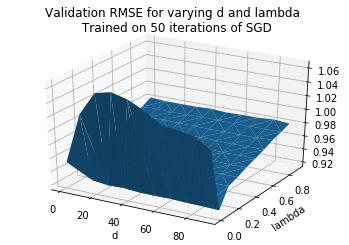

In [7]:
# surface plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(params[:,0],params[:,1],params[:,3])
plt.title("Validation RMSE for varying d and lambda \n Trained on 50 iterations of SGD")
plt.xlabel("d")
plt.ylabel("lambda")

# find optimal parameters
index_min = np.argmin(params[:,3])
d_best = int(params[index_min,0])
lambda_best = params[index_min,1]
print('best parameters: hidden dimension=%.0f, regularization parameter=%.1f' % (d_best, lambda_best))


In [8]:
import mf
from mf import error_function, sgd_minimal
from tqdm import tqdm
############################################
# Initialize parameters
############################################
mu = np.mean(train_rating)
a  = np.zeros(nUsers)
b  = np.zeros(nMovies)
num_iters = 50

############################################
# Validate step size
############################################
# init vectors of possible step sizes
step_sizes = [0.1,0.01,0.001,0.0001,0.00001,0.000001]
num_steps = len(step_sizes)
params_steps = np.zeros(shape=(num_steps,3))
# loop through each step size
for i in tqdm(range(num_steps)):
    # pull out params and init U,V
    U  = np.random.randn(nUsers, d_best)  *.01 # User weights
    V  = np.random.randn(nMovies, d_best) *.01 # Movie features
    step_size = step_sizes[i]
    # train model
    U,V,a,b = sgd_minimal(num_iters,train_user,train_movie,train_rating,step_size,lambda_best,U,V,mu,a,b)
    # calc errors
    train_predictions = predict(train_user, train_movie, U, V, mu, a, b)
    valid_predictions = predict(valid_user, valid_movie, U, V, mu, a, b)

    train_rmse = rmse(train_predictions, train_rating)
    valid_rmse = rmse(valid_predictions, valid_rating)
    # store in params matrix
    params_steps[i,:] = [step_size,train_rmse,valid_rmse]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:45<00:00, 57.56s/it]


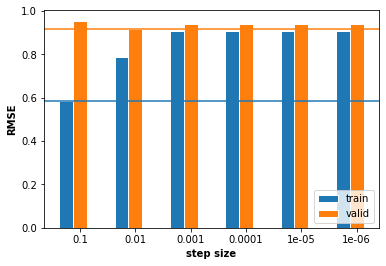

Best step size is: 0.01


In [15]:
### plot code adapted from https://python-graph-gallery.com/11-grouped-barplot/
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = params_steps[:,1]
bars2 = params_steps[:,2]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1,width=barWidth, edgecolor='white', label='train')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='valid')
 
# Add xticks on the middle of the group bars
plt.xlabel('step size', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], params_steps[:,0])

# Add min lines
min_rmse_train = min(params_steps[:,1])
min_rmse_valid = min(params_steps[:,2])
plt.axhline(y=min_rmse_train,color="#1f77b4")
plt.axhline(y=min_rmse_valid,color="#ff7f0e")
 
# Create legend & Show graphic
plt.legend(loc = 'lower right')
plt.show()


best_step_size = step_sizes[np.argmin(params_steps[:,2])]
print("Best step size is: " + str(best_step_size))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]


after training: train_rmse=0.730, valid_rmse=0.914


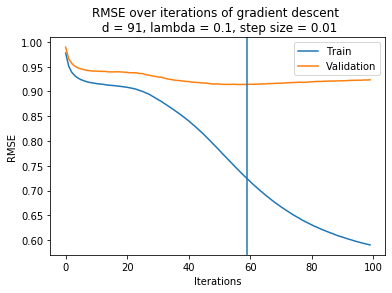

In [12]:
# import mf
from mf import error_function, sgd, sgd_minimal
############################################
# Tunable parameters (you will add more)
############################################

nDims = d_best

############################################
# Initialize parameters
############################################

mu = np.mean(train_rating)
a  = np.zeros(nUsers)
b  = np.zeros(nMovies)
U  = np.random.randn(nUsers, nDims)  *.01 # User weights
V  = np.random.randn(nMovies, nDims) *.01 # Movie features

############################################
# Training and validation
############################################

# TODO: write code to train model and evaluate performance on validation set
# 
#  You are encouraged to define functions in mf.py and import them here.
#
#  predict() is a stub that predicts the overall mean for all user-movie
#  pairs. Update it to take more parameters and make real predictions.


### own code
train_predictions = predict(train_user, train_movie, U, V, mu, a, b)
valid_predictions = predict(valid_user, valid_movie, U, V, mu, a, b)

train_rmse = rmse(train_predictions, train_rating)
valid_rmse = rmse(valid_predictions, valid_rating)

U,V,a,b,train_rmse_hist,valid_rmse_hist = sgd(100,train_user,train_movie,train_rating,best_step_size,lambda_best,U,V,mu,a,b,valid_user, valid_movie,valid_rating)

train_predictions = predict(train_user, train_movie, U, V, mu, a, b)
valid_predictions = predict(valid_user, valid_movie, U, V, mu, a, b)

train_rmse = rmse(train_predictions, train_rating)
valid_rmse = rmse(valid_predictions, valid_rating)

## error history
min_valid = np.argmin(valid_rmse_hist)
plt.plot(train_rmse_hist)
plt.plot(valid_rmse_hist)
plt.title("RMSE over iterations of gradient descent \n d = %.0f, lambda = %.1f, step size = %.2f" % (d_best,lambda_best,best_step_size))
plt.legend(['Train','Validation'])
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.axvline(x=min_valid)

# FINAL TRAINING
# reset weights
a  = np.zeros(nUsers)
b  = np.zeros(nMovies)
U  = np.random.randn(nUsers, nDims)  *.01 # User weights
V  = np.random.randn(nMovies, nDims) *.01 # Movie features

# train with optimal parameters
U,V,a,b = sgd_minimal(min_valid,train_user,train_movie,train_rating,.01,lambda_best,U,V,mu,a,b)
train_predictions = predict(train_user, train_movie, U, V, mu, a, b)
valid_predictions = predict(valid_user, valid_movie, U, V, mu, a, b)
train_rmse = rmse(train_predictions, train_rating)
valid_rmse = rmse(valid_predictions, valid_rating)
print('after training: train_rmse=%.3f, valid_rmse=%.3f' % (train_rmse, valid_rmse))


############################################
# Testing
############################################

# Make and save predictions for test set
test_predictions = predict(test_user, test_movie, U, V,mu, a, b)

np.savetxt('test_predictions.txt', test_predictions)


## Bonus Material: Inspect Predictions for Different Users

After you have learned a good model, you may wish to interpret what it has learned. We can do this by looking at the most positive and most negative predictions for different users
(or the movies that are bumped up or down from the baseline the most).

Read and run the code below to see if you can understand the predictions. (Note: the predictions won't make sense until you have learned a good model!)

In [13]:
all_movies = range(nMovies)

def get_lowest(vals):
    most_negative = np.argsort(vals)
    return most_negative

def get_highest(vals):
    most_negative = np.argsort(vals)
    most_positive = most_negative[::-1]
    return most_positive

k = 8
all_users = range(nUsers)
users_to_examine = all_users[0:5]

for user in users_to_examine:

    # Changes from baseline movie predictions for this user
    delta = np.dot(V, U[user,:])  

    print('*** User %d ***' % (user))
    print('  Top movies')
    for i in get_highest(delta)[0:k]:
        print('    %+.4f  %s' % (delta[i], titles[i]))
    print('')
    
    print('  Bottom movies')
    for i in get_lowest(delta)[0:k]:
        print('    %+.4f  %s' % (delta[i], titles[i]))
    print('')


*** User 0 ***
  Top movies
    +0.6263  Monty Python's Life of Brian (1979)
    +0.5918  City of Lost Children, The (1995)
    +0.5660  Swingers (1996)
    +0.5500  Cook the Thief His Wife & Her Lover, The (1989)
    +0.5453  Sleeper (1973)
    +0.5449  Big Night (1996)
    +0.5433  Legends of the Fall (1994)
    +0.5423  Three Colors: Blue (1993)

  Bottom movies
    -0.8412  Homeward Bound: The Incredible Journey (1993)
    -0.7825  Kull the Conqueror (1997)
    -0.7599  Jungle2Jungle (1997)
    -0.7259  George of the Jungle (1997)
    -0.7115  Dirty Dancing (1987)
    -0.6559  First Knight (1995)
    -0.6538  My Best Friend's Wedding (1997)
    -0.6424  McHale's Navy (1997)

*** User 1 ***
  Top movies
    +0.4301  Old Man and the Sea, The (1958)
    +0.3511  English Patient, The (1996)
    +0.3483  Amistad (1997)
    +0.3313  Kiss Me, Guido (1997)
    +0.3194  Love Jones (1997)
    +0.3188  Boogie Nights (1997)
    +0.3160  Welcome to the Dollhouse (1995)
    +0.3119  Graduate, Th

## More Bonus Material: Interpretation of Weight Vectors as Features

* So far we have described both $\u_i$ and $\v_j$ as *weight vectors* (since we don't have any features of movies and users). But, it is possible to interpret one or both of these vectors as **learned features**. 

* For example, the first learned feature may discover a preference for comedy vs. drama. In this case:
    * The user feature value $u_{i1}$ should be high if the user likes comedies and low if the user likes dramas better.
    * The movie feature value $v_{j1}$ should be high if the movie is a comedy and low if it is a drama. 
    
* Similarly, feature 2 might describe whether a movie is geared toward kids or adults

* In practice, the feature interpretations often find recognizable patterns but are not quite so clean to describe as the two examples above.

Run the code below to examine the movies with the highest and lowest feature values for some of the features in your learned model.

In [14]:
k = 5

features_to_examine = np.arange(0,10)

for feature in features_to_examine:

    feature_vals = V[:,feature]
    
    print ('*** Feature %d ***' % (feature))
    print ('  Movies with highest feature value')
    for i in get_highest(feature_vals)[0:k]:
        print ('    %+.4f  %s' % (feature_vals[i], titles[i]))
    print ('')
    
    print ('  Movies with lowest feature value')
    for i in get_lowest(feature_vals)[0:k]:
        print ('    %+.4f  %s' % (feature_vals[i], titles[i]))
    print ('')


*** Feature 0 ***
  Movies with highest feature value
    +0.4599  I Know What You Did Last Summer (1997)
    +0.3487  Lost Highway (1997)
    +0.3428  Beavis and Butt-head Do America (1996)
    +0.2823  Army of Darkness (1993)
    +0.2692  Soul Food (1997)

  Movies with lowest feature value
    -0.3162  Piano, The (1993)
    -0.3098  Natural Born Killers (1994)
    -0.2776  Steel (1997)
    -0.2733  Matilda (1996)
    -0.2634  That Darn Cat! (1997)

*** Feature 1 ***
  Movies with highest feature value
    +0.2772  Tin Cup (1996)
    +0.2513  Die Hard: With a Vengeance (1995)
    +0.2473  Star Trek: The Motion Picture (1979)
    +0.2352  Client, The (1994)
    +0.2309  Star Trek III: The Search for Spock (1984)

  Movies with lowest feature value
    -0.2603  Young Poisoner's Handbook, The (1995)
    -0.2442  Boogie Nights (1997)
    -0.2286  Trainspotting (1996)
    -0.2271  George of the Jungle (1997)
    -0.2218  Celluloid Closet, The (1995)

*** Feature 2 ***
  Movies with highes